# Physionet 2020 Challenge Overview

This notebook contains a technical overview of the Physionet 2020 Challenge of 12-Lead ECG classification.

## Scoring Function

The official phase scoring metric is defined ([reference](https://physionetchallenges.github.io/2020/#scoring)):

Let $C = [c_i]$ be a collection of diagnoses.
We compute a multi-class confusion matrix $A = [a_{ij}]$, where $a_{ij}$ is the number of recordings in a database that were classified as belonging to class $c_i$ but actually belong to class $c_j$.
We assign different weights $A = [a_{ij}]$ to different entries in this matrix based on the similarity of treatments or differences in risks.
The score $s$ is given by $s = \sum_{ij}(w_{ij}a_{ij})$, which is a generalized version of the traditional accuracy metric.
The score $s$ is then normalized so that a classifier that always outputs the true class(es) receives a score of 1 and an inactive classifier that always outputs the normal class receives a score of 0.

In [1]:
import json
import math
import os
import re
from glob import glob
from collections import OrderedDict

import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import scipy.signal as ss
import wfdb
from biosppy.signals.ecg import hamilton_segmenter
from joblib import Parallel, delayed, dump, load
from matplotlib import ticker

from util.evaluate_12ECG_score import load_table, load_weights 

In [2]:
# Load the SNOMED_CT Mapping to DX
with open("data/snomed_ct_dx_map.json", "r") as f:
    SNOMED_CODE_MAP = json.load(f)

In [3]:
rows, cols, vals = load_table("evaluation-2020/weights.csv")

print("Number of scored labels: ", len(rows))
assert rows == cols, "rows and cols mismatch"

scored_codes = rows

Number of scored labels:  27


In [4]:
pd.read_csv("evaluation-2020/dx_mapping_scored.csv")

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


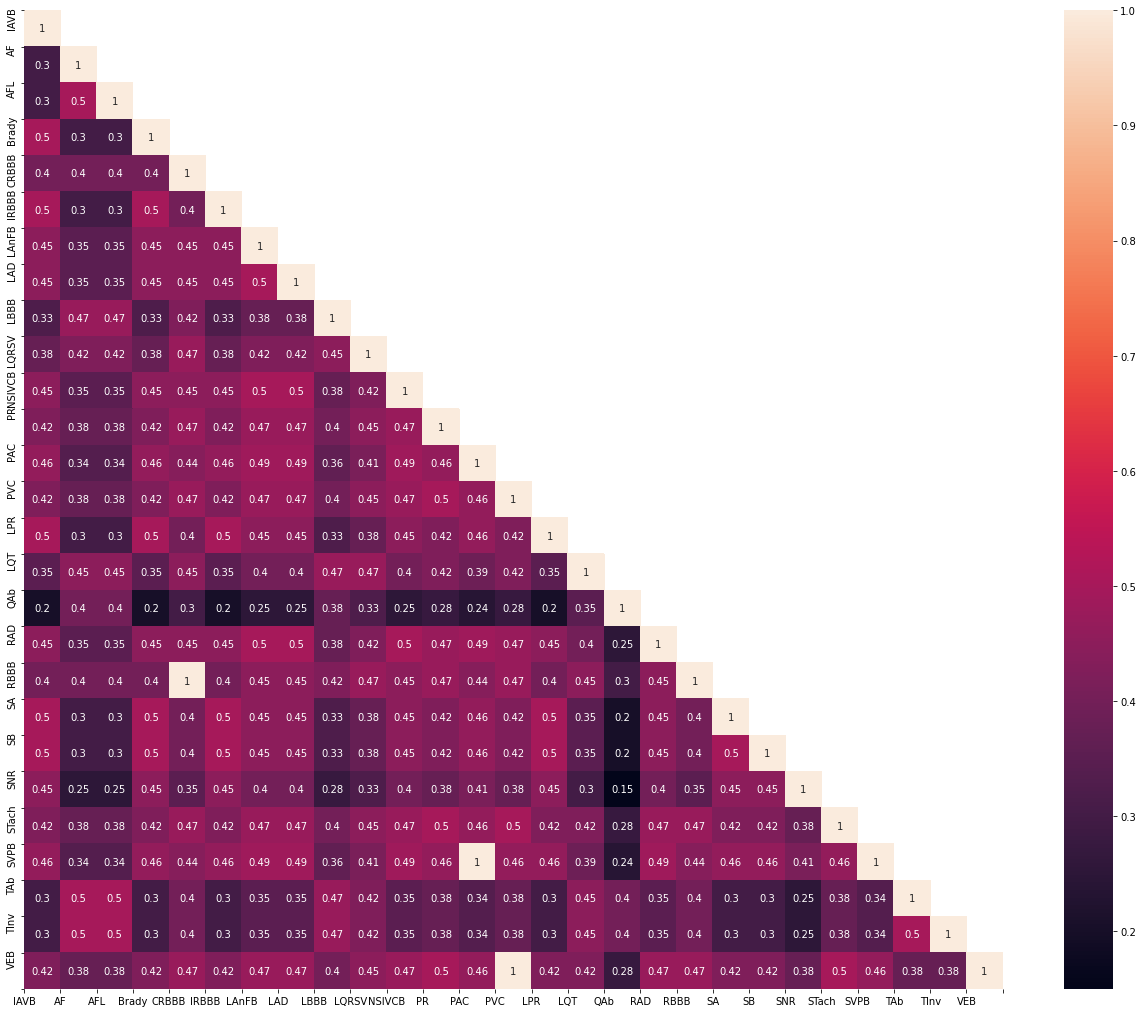

In [5]:
row_texts = []
for row in rows:
    abrv, dx = SNOMED_CODE_MAP.get(row, (f"{row}?", "unknown"))
    row_texts.append(abrv)

col_texts = []
for col in cols:
    abrv, dx = SNOMED_CODE_MAP.get(col, (f"{col}?", "unknown"))
    col_texts.append(abrv)


fig = plt.figure(figsize=(22,18))
# ax = fig.add_subplot(111)
# cax = ax.matshow(vals)
# fig.colorbar(cax)

mask = np.zeros_like(vals)
mask[np.triu_indices(len(vals), 1)] = True
# print(mask)

ax = sns.heatmap(vals, annot=True, mask=mask, square=True)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xticklabels([""] + col_texts)
ax.set_yticklabels([""] + row_texts)
plt.show()


## Dataset Overview

The [data from this challenge](https://physionetchallenges.github.io/2020/#-data) come from multiple sources.

1. 6,877 recordings from China Physiological Signal Challenge in 2018 (CPSC2018):  https://storage.cloud.google.com/physionet-challenge-2020-12-lead-ecg-public/PhysioNetChallenge2020_Training_CPSC.tar.gz 
2. 3,453 recordings from China 12-Lead ECG Challenge Database: https://storage.cloud.google.com/physionet-challenge-2020-12-lead-ecg-public/PhysioNetChallenge2020_Training_2.tar.gz
3. 74 recordings from the St Petersburg INCART 12-lead Arrhythmia Database: https://storage.cloud.google.com/physionet-challenge-2020-12-lead-ecg-public/PhysioNetChallenge2020_Training_StPetersburg.tar.gz 
4. 516 recordings from the PTB Diagnostic ECG Database: https://storage.cloud.google.com/physionet-challenge-2020-12-lead-ecg-public/PhysioNetChallenge2020_Training_PTB.tar.gz
5. 21,837 recordings from the PTB-XL electrocardiography Database: https://storage.cloud.google.com/physionet-challenge-2020-12-lead-ecg-public/PhysioNetChallenge2020_PTB-XL.tar.gz
6. 10,344 recordings from a Georgia 12-Lead ECG Challenge Database: https://storage.cloud.google.com/physionet-challenge-2020-12-lead-ecg-public/PhysioNetChallenge2020_Training_E.tar.gz


In [6]:
files = tuple(sorted(glob("data/**/*.hea")))
record_names = [file.split(".hea")[0] for file in files]

print("Number of records:", len(record_names))

Number of records: 43101


In [7]:
def record_stats(record_name):
    """Convert a wfdb record into a structured numpy array.
    """
    record = wfdb.rdrecord(record_name)
    signal = record.p_signal
    seq_len, num_signals = signal.shape
    sampling_rate = float(record.fs)

    # median filter signal (intended to remove sharp peaks)
    f_signal = ss.medfilt(signal)
    
    order = int(0.3 * sampling_rate)
    if order % 2 == 0:
        order += 1
    sig_filter = ss.firwin(
        numtaps=order, cutoff=[3, 45], pass_zero=False, fs=sampling_rate
    )
    f_signal = ss.filtfilt(b=sig_filter, a=np.array([1, ]), x=f_signal, axis=0)

    assert len(record.sig_name) == num_signals, "signal names mismatch number of signals"

    meta = {
        "age": float("nan"), # number of years old
        "sex": float("nan"),  # 0 for male, 1 for female, nan for other
        "dx": []
    }

    for comment in record.comments:
        dx_grp = re.search(r"Dx: (?P<dx>.*)$", comment)
        if dx_grp:
            raw_dx = dx_grp.group("dx").split(",")
            dx = []
            for dxi in raw_dx:
                snomed_code = int(dxi)
                dx.append(snomed_code)

            meta["dx"] = dx
            continue

        age_grp = re.search(r"Age: (?P<age>.*)$", comment)
        if age_grp:
            meta["age"] = float(age_grp.group("age"))
            if not np.isfinite(meta["age"]):
                meta["age"] = float("nan")
            continue

        sx_grp = re.search(r"Sex: (?P<sx>.*)$", comment)
        if sx_grp:
            if sx_grp.group("sx").upper().startswith("F"):
                meta["sex"] = 1
            elif sx_grp.group("sx").upper().startswith("M"):
                meta["sex"] = 0
            continue
    
#     print(meta)
    
    data = [record_name, sampling_rate, meta["age"], meta["sex"], tuple(meta["dx"]),]
    dtype = [("record_name", np.unicode_, 30), ("sampling_rate", "f4"), ("age", "f4"), ("sex", "f4"), ("dx", np.object)]
    
    # Construct summary stats for raw p_signal amplitudes per lead
    for sig_idx, sig_name in enumerate(record.sig_name):
        lead_sig = f_signal[:, sig_idx]

        # Filtered Signal Amplitudes
        lead_stats = sp.stats.describe(lead_sig)
        data.append(lead_stats.minmax[0])
        dtype.append((f'p_signal_{sig_name}_min', "<f4"))
        data.append(lead_stats.minmax[1])
        dtype.append((f'p_signal_{sig_name}_max', "<f4"))
        data.append(lead_stats.variance)
        dtype.append((f'p_signal_{sig_name}_mean', "<f4"))
        data.append(lead_stats.mean)
        dtype.append((f'p_signal_{sig_name}_variance', "<f4"))
        data.append(lead_stats.skewness)
        dtype.append((f'p_signal_{sig_name}_skewness', "<f4"))
        data.append(lead_stats.kurtosis)
        dtype.append((f'p_signal_{sig_name}_kurtosis', "<f4"))
    
        # Hamilton Segmenter detected R-Peaks
        try:
            sig_rpeaks = hamilton_segmenter(lead_sig, sampling_rate=sampling_rate)[0]
            # Convert R peaks into heartrate (beats per minute)
            hr = [(sampling_rate / spb) * 60 for spb in np.diff(sig_rpeaks)]            
            hr_stats = sp.stats.describe(hr)
            data.append(hr_stats.minmax[0])
            dtype.append((f'hr_{sig_name}_min', "<f4"))
            data.append(hr_stats.minmax[1])
            dtype.append((f'hr_{sig_name}_max', "<f4"))
            data.append(hr_stats.variance)
            dtype.append((f'hr_{sig_name}_mean', "<f4"))
            data.append(hr_stats.mean)
            dtype.append((f'hr_{sig_name}_variance', "<f4"))
            data.append(hr_stats.skewness)
            dtype.append((f'hr_{sig_name}_skewness', "<f4"))
            data.append(hr_stats.kurtosis)
            dtype.append((f'hr_{sig_name}_kurtosis', "<f4"))

        except Exception as e:
            data.append(float("NaN"))
            dtype.append((f'hr_{sig_name}_min', "<f4"))
            data.append(float("NaN"))
            dtype.append((f'hr_{sig_name}_max', "<f4"))
            data.append(float("NaN"))
            dtype.append((f'hr_{sig_name}_mean', "<f4"))
            data.append(float("NaN"))
            dtype.append((f'hr_{sig_name}_variance', "<f4"))
            data.append(float("NaN"))
            dtype.append((f'hr_{sig_name}_skewness', "<f4"))
            data.append(float("NaN"))
            dtype.append((f'hr_{sig_name}_kurtosis', "<f4"))

#     print(data, len(data))
#     print(np.dtype(dtype), len(dtype))
    return np.array([tuple(data),], dtype=np.dtype(dtype))

# sp.stats.describe([])
# record_stats(record_names[0])

In [8]:
rn = record_names[0]
r_stats = record_stats(rn)
r_stats = (dict(zip(r_stats.dtype.names, r_stats[0])))
print(r_stats)
# for k, v in r_stats.items():
#     print(f"{k:>20}", v)


{'record_name': 'data/Training_2/Q0001', 'sampling_rate': 500.0, 'age': 53.0, 'sex': 0.0, 'dx': (164867002, 427084000), 'p_signal_I_min': -0.23220628, 'p_signal_I_max': 0.16497625, 'p_signal_I_mean': 0.001609363, 'p_signal_I_variance': -0.00017821044, 'p_signal_I_skewness': -1.5822569, 'p_signal_I_kurtosis': 10.388048, 'hr_I_min': 100.67114, 'hr_I_max': 103.80623, 'hr_I_mean': 0.8130832, 'hr_I_variance': 102.68128, 'hr_I_skewness': -0.9733416, 'hr_I_kurtosis': 0.112298094, 'p_signal_II_min': -0.29247975, 'p_signal_II_max': 0.35202846, 'p_signal_II_mean': 0.004230662, 'p_signal_II_variance': 4.344257e-05, 'p_signal_II_skewness': 0.9988081, 'p_signal_II_kurtosis': 8.731618, 'hr_II_min': 100.67114, 'hr_II_max': 103.80623, 'hr_II_mean': 0.8130832, 'hr_II_variance': 102.68128, 'hr_II_skewness': -0.9733416, 'hr_II_kurtosis': 0.112298094, 'p_signal_III_min': -0.22276807, 'p_signal_III_max': 0.36293778, 'p_signal_III_mean': 0.0032052214, 'p_signal_III_variance': -4.9984803e-05, 'p_signal_III_s

In [9]:
if os.path.isfile("signal_summary_stats.jld"):
    signal_summary_stats = load("signal_summary_stats.jld")
else:
    signal_summary_stats = np.concatenate(
        Parallel(verbose=1, n_jobs=-1)(
            delayed(record_stats)(rn) for rn in record_names
        ))

    dump(signal_summary_stats, "signal_summary_stats.jld")

In [10]:
# print(scored_codes)
label_map = {}
used = set()
for ss_stat in signal_summary_stats:
    is_scored = any([str(dx) in scored_codes for dx in ss_stat["dx"]])
    if not is_scored:
        label_records = label_map.get("OTHER", [])
        label_records.append(ss_stat["record_name"])
        label_map[str(ss_stat["dx"][0])] = label_records
        used.add(ss_stat["record_name"])
        continue

    for dx in ss_stat["dx"]:
        if str(dx) in scored_codes and ss_stat["record_name"] not in used:
            label_records = label_map.get(str(dx), [])
            label_records.append(ss_stat["record_name"])
            label_map[str(dx)] = label_records
            used.add(ss_stat["record_name"])


In [11]:
for k, v in label_map.items():
    if k in scored_codes:
        print(k, SNOMED_CODE_MAP.get(k), v[:2])
#     else:
#         print(k, ["Other", "Other"], v[0])

print("OTHER")
for k, v in label_map.items():
    if k not in scored_codes:
        print(k, SNOMED_CODE_MAP.get(k), v[0])
        break
#     else:
#         print(k, ["Other", "Other"], v[0])


427084000 ['STach', 'sinus tachycardia'] ['data/Training_2/Q0001', 'data/Training_2/Q0022']
427172004 ['PVC', 'premature ventricular contractions'] ['data/Training_2/Q0010', 'data/Training_2/Q0013']
426627000 ['Brady', 'bradycardia'] ['data/Training_2/Q0012', 'data/Training_2/Q0023']
63593006 ['SVPB', 'supraventricular premature beats'] ['data/Training_2/Q0017', 'data/Training_2/Q0134']
284470004 ['PAC', 'premature atrial contraction'] ['data/Training_2/Q0026', 'data/Training_2/Q0040']
713427006 ['CRBBB', 'complete right bundle branch block'] ['data/Training_2/Q0027', 'data/Training_2/Q0036']
164909002 ['LBBB', 'left bundle branch block'] ['data/Training_2/Q0033', 'data/Training_2/Q0041']
164889003 ['AF', 'atrial fibrillation'] ['data/Training_2/Q0048', 'data/Training_2/Q0103']
270492004 ['IAVB', '1st degree av block'] ['data/Training_2/Q0050', 'data/Training_2/Q0074']
713426002 ['IRBBB', 'incomplete right bundle branch block'] ['data/Training_2/Q0077', 'data/Training_2/Q0136']
1648900

### Label 'Outlier' Detection

Still investigating how to best distinguish noisy ECG records from clean training data.

In [12]:
desc = {}
for name in signal_summary_stats.dtype.names:
    if name in ("record_name", "dx"):
        continue
    desc[name] = sp.stats.describe(signal_summary_stats[name], nan_policy="omit")

In [13]:
# determine outliers, based on desc[name]
# outliers defined as over 2 standard deviations away from the mean or contains a NaN

desc_outliers = {}
for name, desc_stats in desc.items():
    std = np.sqrt(desc_stats.variance)
    above = signal_summary_stats[name] > desc_stats.mean + (2 * std)
    below = signal_summary_stats[name] < desc_stats.mean - (2 * std)
    is_nan = np.isnan(signal_summary_stats[name])

    outliers = np.logical_or(above,below,)
    outliers = np.logical_or(outliers, is_nan)

    desc_outliers[name] = signal_summary_stats[outliers]["record_name"]

In [14]:
mean_outliers = []
max_outliers = []
min_outliers = []
all_outliers = []
for k, v in desc_outliers.items():
    print(f"{len(v)} outliers for {k}")
    if "mean" in k:
        mean_outliers += list(v)
    if "max" in k:
        max_outliers += list(v)
    if "min" in k:
        min_outliers += list(v)
    all_outliers += list(v)
#     print(v[:3])

all_outliers = list(set(all_outliers))

print()
print(f"number of outlier records: {len(all_outliers)} ({len(all_outliers) / len(record_names) * 100:.2f}%)")

590 outliers for sampling_rate
2101 outliers for age
1 outliers for sex
609 outliers for p_signal_I_min
972 outliers for p_signal_I_max
163 outliers for p_signal_I_mean
460 outliers for p_signal_I_variance
2322 outliers for p_signal_I_skewness
693 outliers for p_signal_I_kurtosis
2168 outliers for hr_I_min
563 outliers for hr_I_max
242 outliers for hr_I_mean
1895 outliers for hr_I_variance
2339 outliers for hr_I_skewness
243 outliers for hr_I_kurtosis
1600 outliers for p_signal_II_min
1093 outliers for p_signal_II_max
519 outliers for p_signal_II_mean
471 outliers for p_signal_II_variance
2774 outliers for p_signal_II_skewness
423 outliers for p_signal_II_kurtosis
2077 outliers for hr_II_min
260 outliers for hr_II_max
68 outliers for hr_II_mean
1729 outliers for hr_II_variance
1846 outliers for hr_II_skewness
159 outliers for hr_II_kurtosis
1714 outliers for p_signal_III_min
2081 outliers for p_signal_III_max
1046 outliers for p_signal_III_mean
431 outliers for p_signal_III_variance
14

### Label 'Outlier' Ratio

For each of the labels that we care about, what is the ratio of 'outliers' to not outliers?

In [15]:
# print(scored_codes)
# print(all_outliers)

label_outlier_counter = {
    "ignored": 0
}
label_counter = {
    "ignored" : 0
}

for idx, sss in enumerate(signal_summary_stats):
    contained_scored_code = any([str(dx) in scored_codes for dx in sss["dx"]])

    if contained_scored_code:
        for dx in sss["dx"]:
            if str(dx) in scored_codes:
                if sss["record_name"] in all_outliers:
                    label_outlier_counter[dx] = label_outlier_counter.get(dx, 0) + 1
                label_counter[dx] = label_counter.get(dx, 0) + 1
    else:
        if sss["record_name"] in all_outliers:
            label_outlier_counter["ignored"] += 1
        label_counter["ignored"] += 1
    
    if idx % 1000 == 0:
        print(idx, end="\r")
print("done")

done0


In [16]:
for k, v in label_outlier_counter.items():
    v_total = label_counter[k]
    if k == "ignored":
        print(f"{v} outliers, unscored category ({v/v_total * 100:.3f}% of {v_total})")
    else:
        abrv, dx = SNOMED_CODE_MAP[str(k)]
        print(f"{v} outliers, {dx} ({v/v_total * 100:.3f}% of {v_total})")


3224 outliers, unscored category (60.239% of 5352)
2181 outliers, sinus tachycardia (90.799% of 2402)
159 outliers, premature ventricular contractions (84.574% of 188)
1641 outliers, premature atrial contraction (70.550% of 2326)
638 outliers, complete right bundle branch block (93.411% of 683)
195 outliers, bradycardia (67.708% of 288)
896 outliers, left bundle branch block (86.071% of 1041)
2514 outliers, atrial fibrillation (72.345% of 3475)
1646 outliers, 1st degree av block (68.755% of 2394)
1245 outliers, incomplete right bundle branch block (77.281% of 1611)
246 outliers, atrial flutter (78.344% of 314)
168 outliers, supraventricular premature beats (78.140% of 215)
293 outliers, pacing rhythm (97.993% of 299)
271 outliers, ventricular ectopic beats (68.608% of 395)
3081 outliers, t wave abnormal (65.932% of 4673)
759 outliers, t wave inversion (68.255% of 1112)
14095 outliers, sinus rhythm (67.615% of 20846)
1892 outliers, right bundle branch block (78.768% of 2402)
704 outlier

In [17]:
for name in signal_summary_stats.dtype.names:
    if name in ("record_name", "dx"):
        continue
    plot_vals = signal_summary_stats[name][~np.isnan(signal_summary_stats[name])]
#     fig, ax = plt.subplots(figsize=(8, 1), dpi=100)
    
    k2, p = sp.stats.normaltest(plot_vals)
    alpha = 1e-3
    print(k2, p)
    if p < alpha:
        print(f"Reject null hypothesis not normal distribution, p={p:.4f}, alpha={alpha}")
    else:
        print("Cannot reject null hypothesis")
#     ax.set_title(f"{name}: {str(sp.stats.describe(plot_vals))}")
#     ax.boxplot(plot_vals, labels=(name,), vert=False)
#     plt.show()

59554.585452172614 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
1938.379794867421 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
148505.11273110946 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
119448.4795415619 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
92767.92452415885 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
198766.9319884372 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
134224.7702618896 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
11503.882458670463 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
61418.810955473964 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
5786.862811284011 0.0
Reject null hypothesis not normal distribution, p=0.0000, alpha=0.001
82570.7903752858 0.0
Reject null hypothesis not normal distribution, p=0.000

## Plotting ECG Record


In [18]:
def pretty_plot_record(
    signal,
    sig_names=('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'),
    run_segmenter=True,
    fs=500,
    scale=3,
    y_tick_lim=4.0
):
    #this plotting code is inefficient
    sig_len, num_leads = signal.shape
    assert len(sig_names) == num_leads, "Number of signal leads mismatch signal names"
    
    duration = sig_len / fs
    x = np.linspace(0, duration, sig_len)


    # median filter signal (intended to remove sharp peaks)
    f_signal = ss.medfilt(signal)
    
    order = int(0.3 * fs)
    if order % 2 == 0:
        order += 1
    sig_filter = ss.firwin(
        numtaps=order, cutoff=[3, 45], pass_zero=False, fs=fs
    )
    f_signal = ss.filtfilt(b=sig_filter, a=np.array([1, ]), x=f_signal, axis=0)

    # x_axis: 0.04 for small cells, 0.2 for large cells(5 small cells)
    minor_x_ticks = np.linspace(0, math.ceil(duration), math.ceil(duration) * 25 + 1)
    minor_x_ticks = [mt for mt in minor_x_ticks if mt <= max(x)]
    major_x_ticks = [val for idx, val in enumerate(minor_x_ticks) if idx % 5 == 0]

    scale_x = duration * scale

    # one pass required to determine all minor y ticks for each lead
    for sig_idx, sig_name in enumerate(sig_names):
        lead_sig = signal[:, sig_idx]
        filtered_lead_sig = f_signal[:, sig_idx]
        nk_cleaned_sig = nk.ecg_clean(lead_sig, sampling_rate=fs)

        if run_segmenter:
            try:
                sig_rpeaks = list(hamilton_segmenter(filtered_lead_sig, sampling_rate=fs)[0])
            except:
                sig_rpeaks = []
        else:
            sig_rpeaks = []
        # y_axis: 0.1 for small cells, 0.5 for large cells

        # if y_tick_min/max is less than or greater than y_tick_lim, cap it at y_tick_lim
        y_tick_min = max(-y_tick_lim, math.floor(min(lead_sig) * 2) / 2)
        y_tick_max = min(y_tick_lim, math.ceil(max(lead_sig) * 2) / 2)
        y_tick_range = (y_tick_max - y_tick_min)

        minor_y_ticks = np.linspace(y_tick_min, y_tick_max, int(y_tick_range * 10) + 1)
        major_y_ticks = [val for idx, val in enumerate(minor_y_ticks) if idx % 5 == 0]

        x_y_ratio = len(minor_x_ticks) / len(minor_y_ticks)
        fig, ax = plt.subplots(figsize=(scale_x, scale_x / x_y_ratio), dpi=100)

        print(sig_name)
        ax.set_ylim(y_tick_min, y_tick_max)
        ax.plot(x, lead_sig, color="grey", alpha=0.7)
        ax.plot(x, filtered_lead_sig, '-gD', color="green", alpha=0.7, markevery=sig_rpeaks)
        ax.plot(x, nk_cleaned_sig, color="red", alpha=0.7)
        
        ax.legend(["Raw", "Filtered", "Neurokit"])

        ax.set_ylabel(f'{sig_name} mV')
        ax.set_xlabel(f'seconds')
        ax.set_xticks(minor_x_ticks, minor=True)
        ax.set_xticks(major_x_ticks, minor=False)
        ax.set_yticks(minor_y_ticks, minor=True)
        ax.set_yticks(major_y_ticks, minor=False)

        ax.grid(b=True, which="major", axis="both",
                color="pink", linestyle="solid", linewidth=1)
        ax.grid(b=True, which="minor", axis="both",
                color="pink", linestyle="solid", linewidth=0.25)

        # minimum and maximum, capped to 2mV each direction
        #print(min(lead_sig), max(lead_sig))
        #sig_min = min(lead_sig)
        plt.show()

In [19]:
desc_outliers["p_signal_I_kurtosis"][0]

'data/Training_2/Q0010'

I


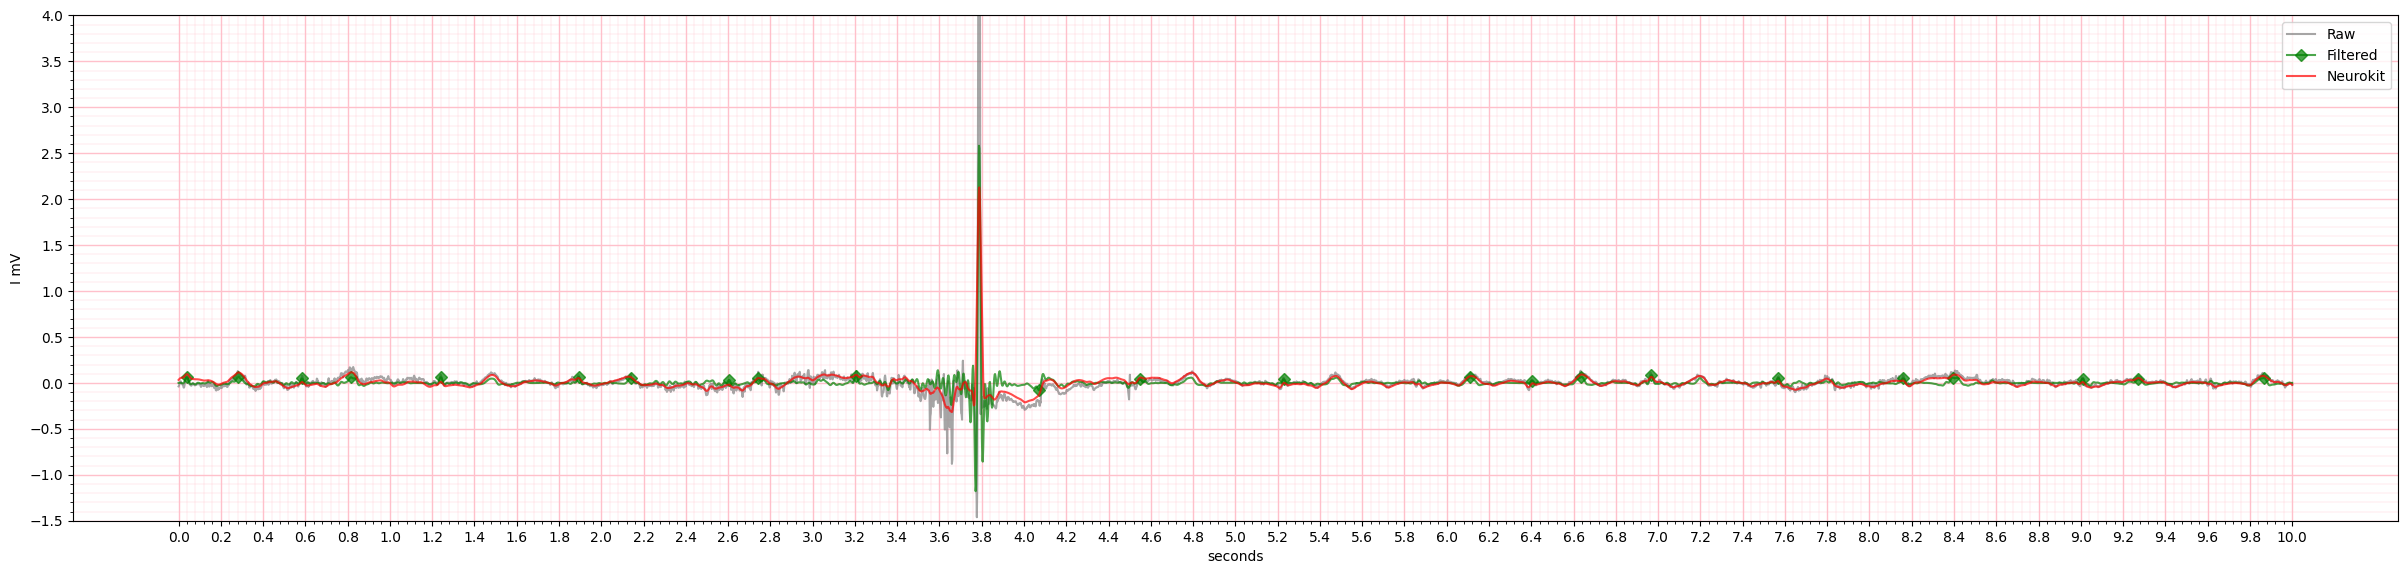

II


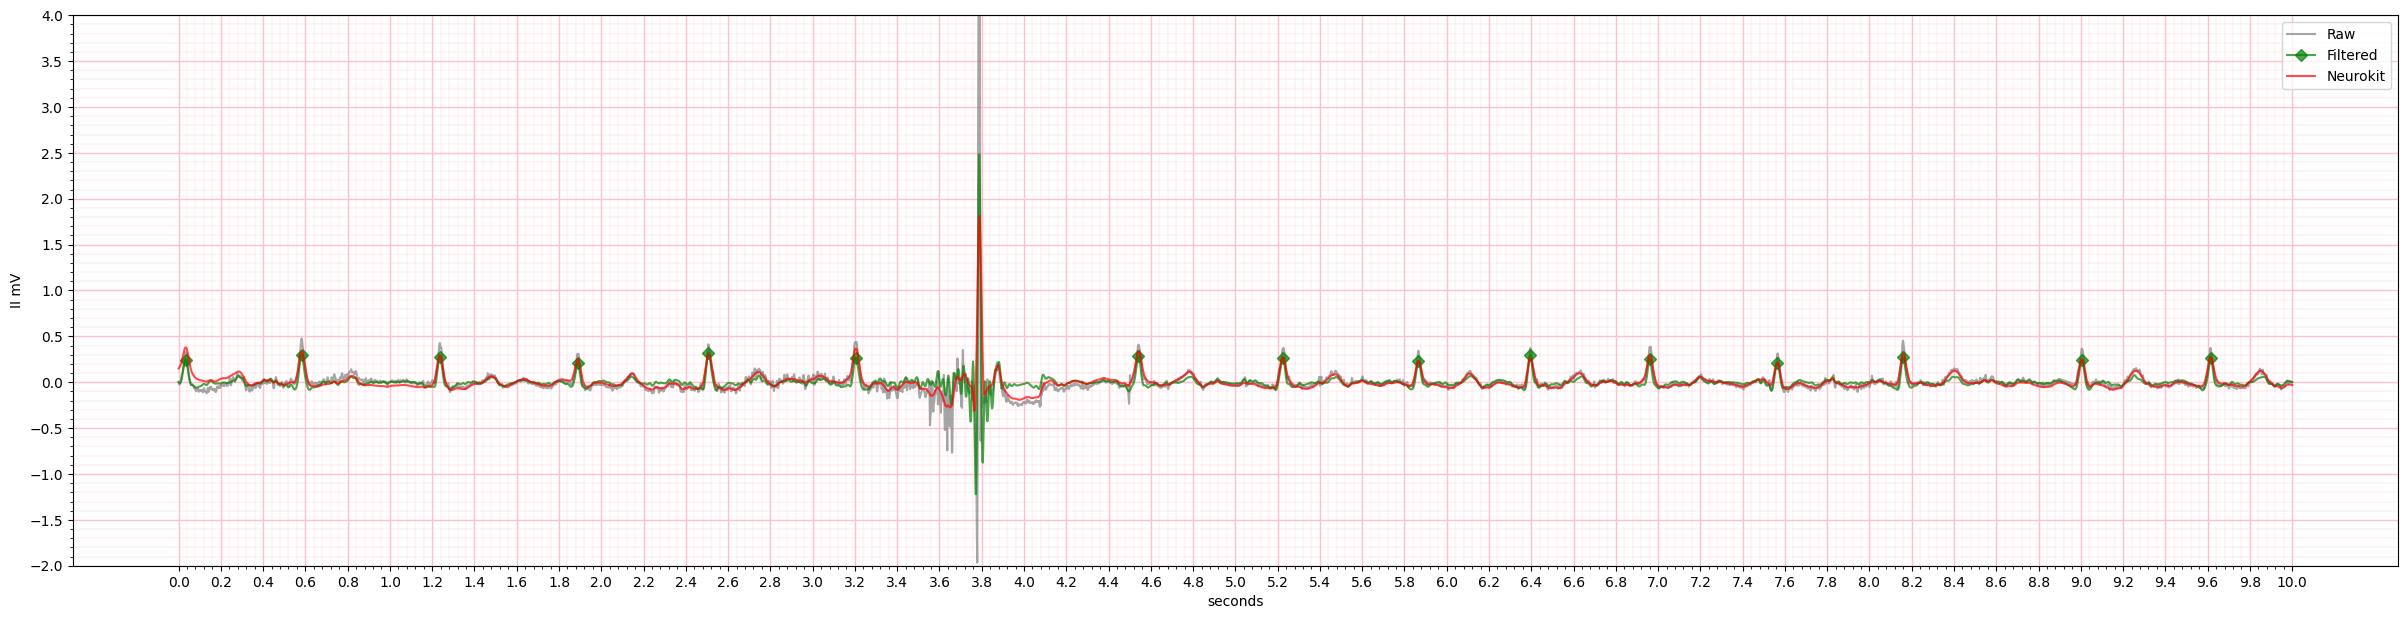

III


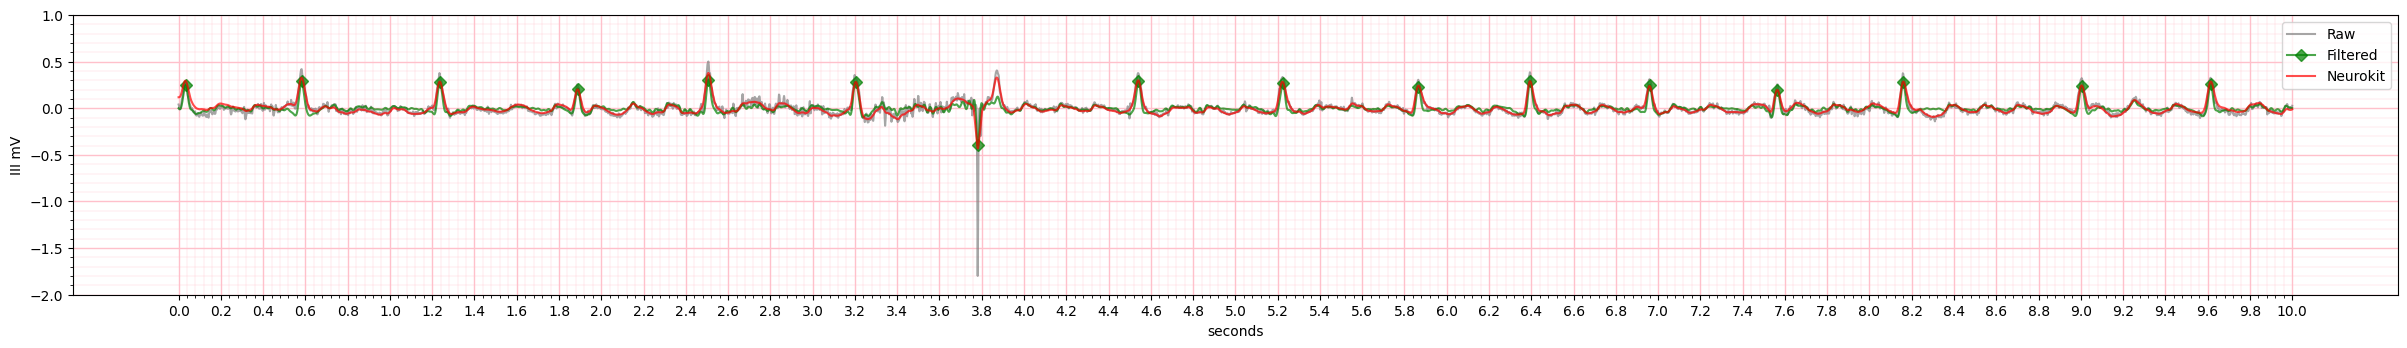

aVR


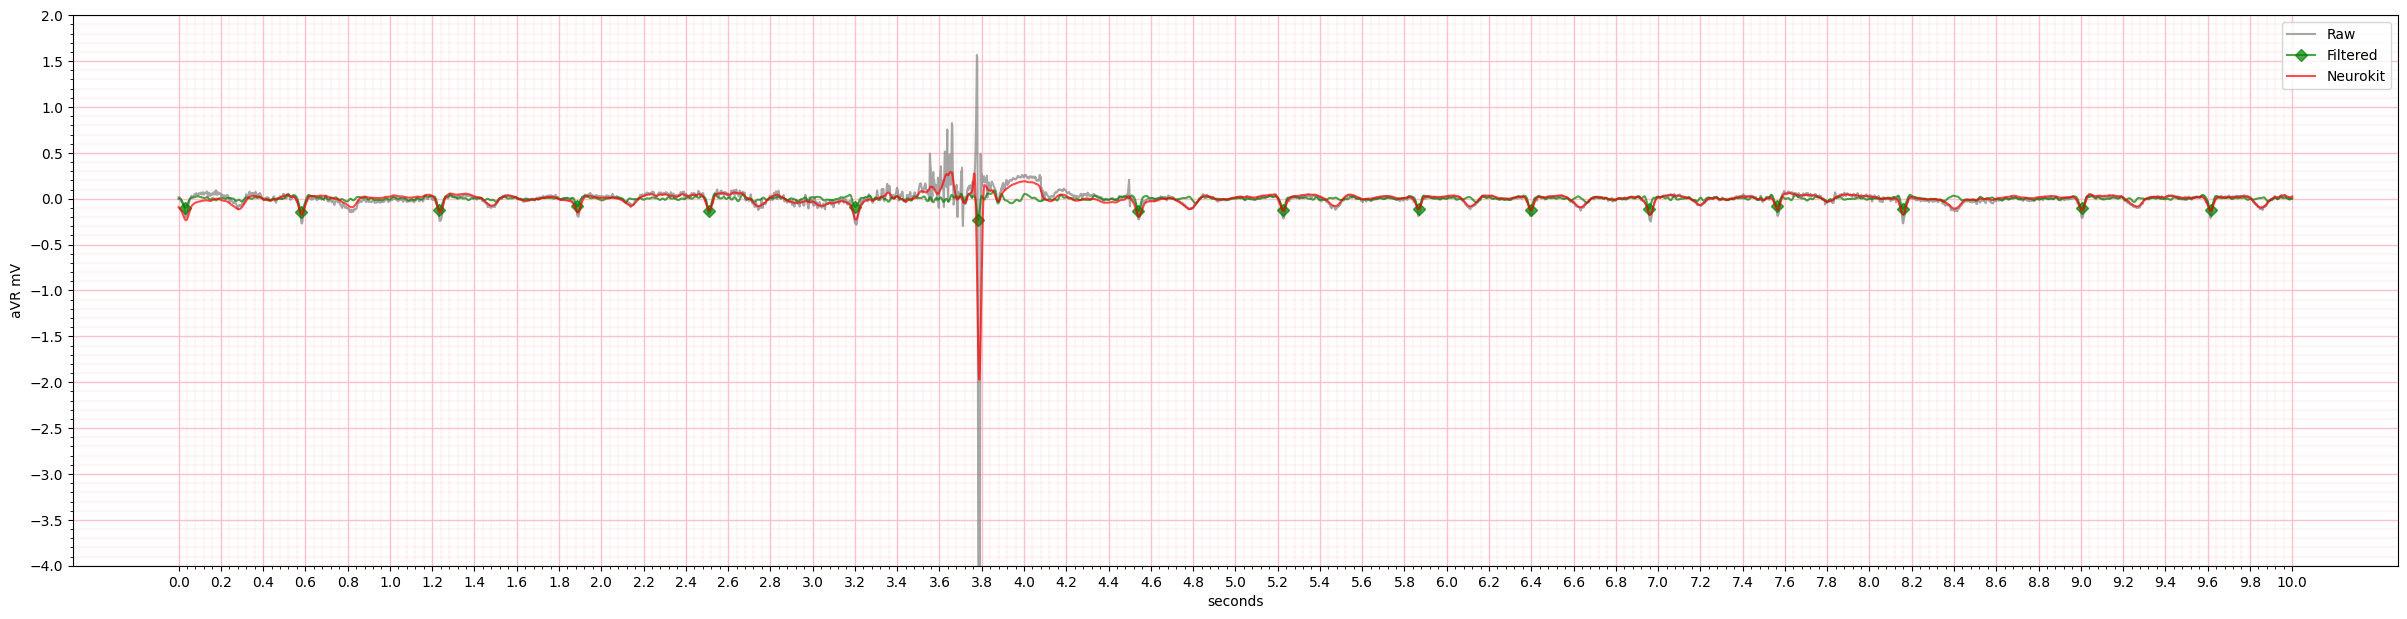

aVL


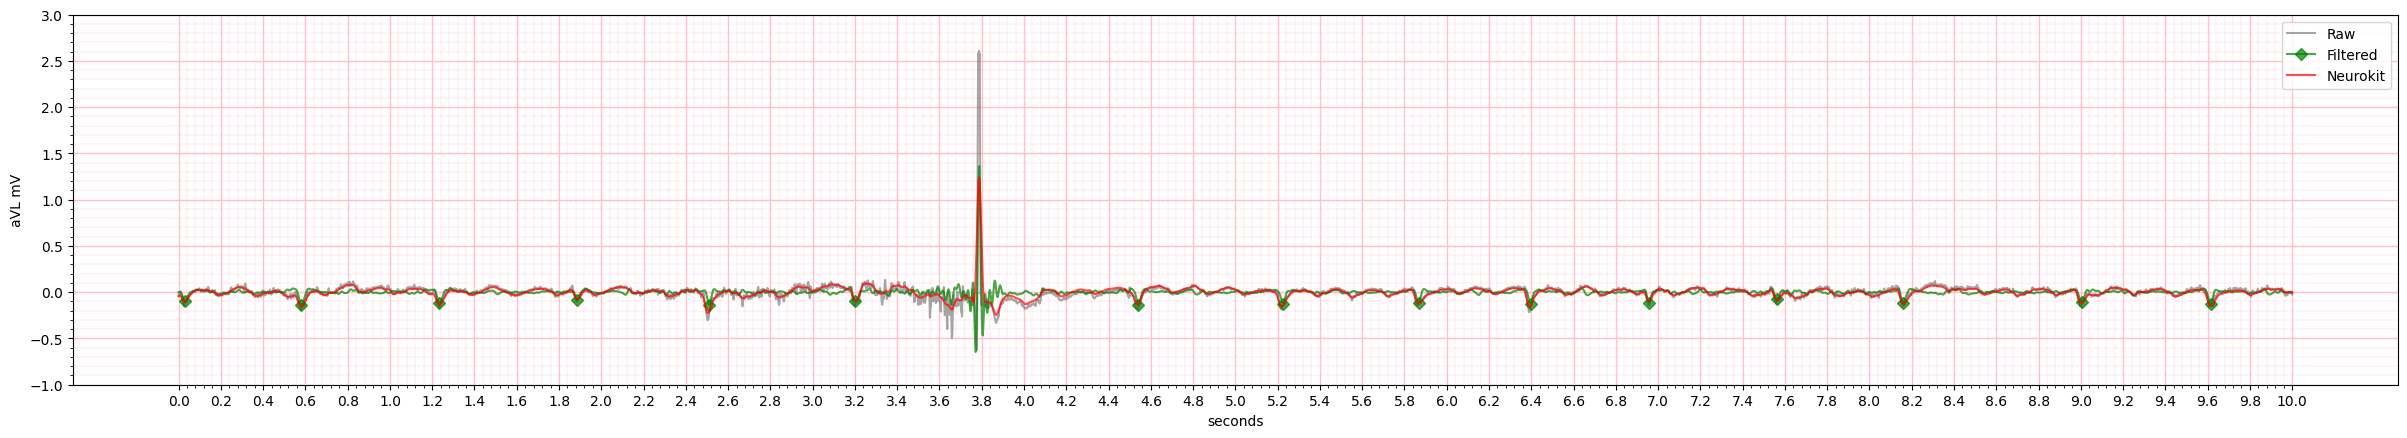

aVF


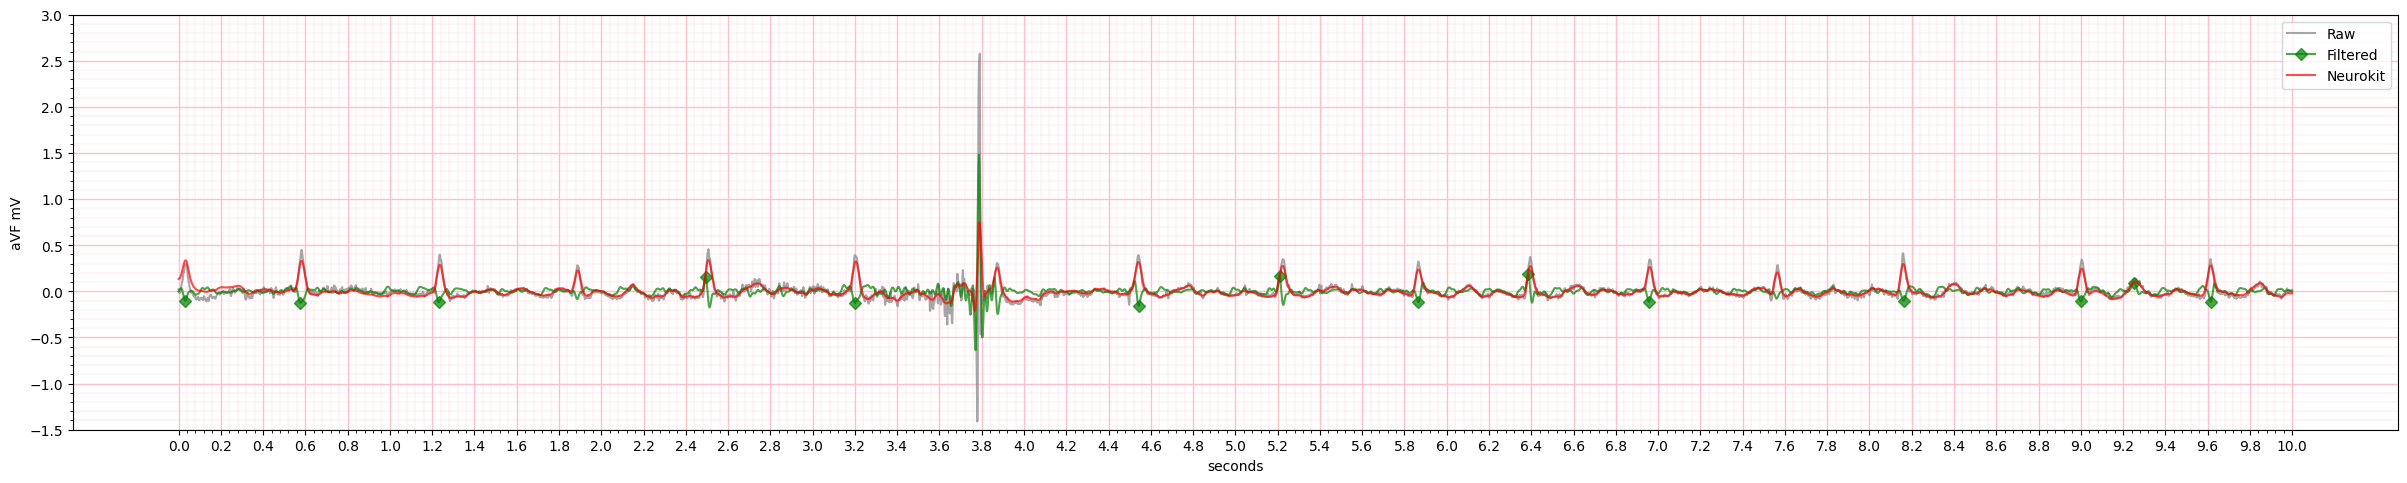

V1


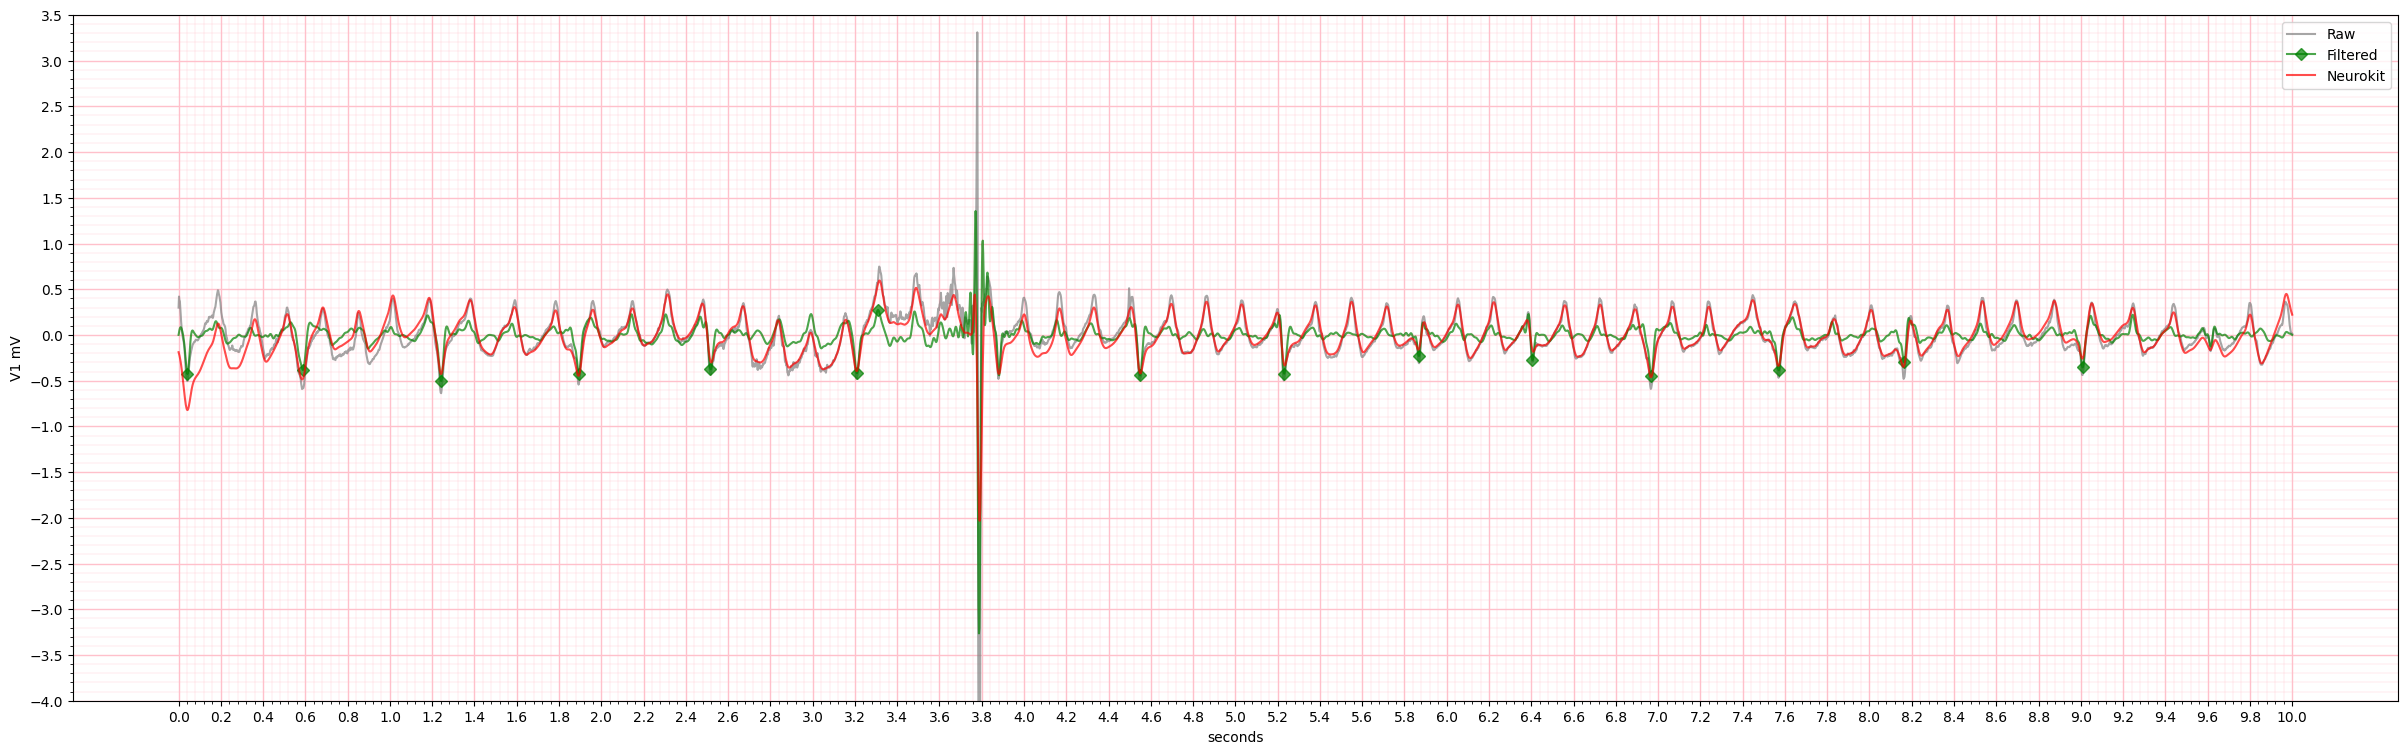

V2


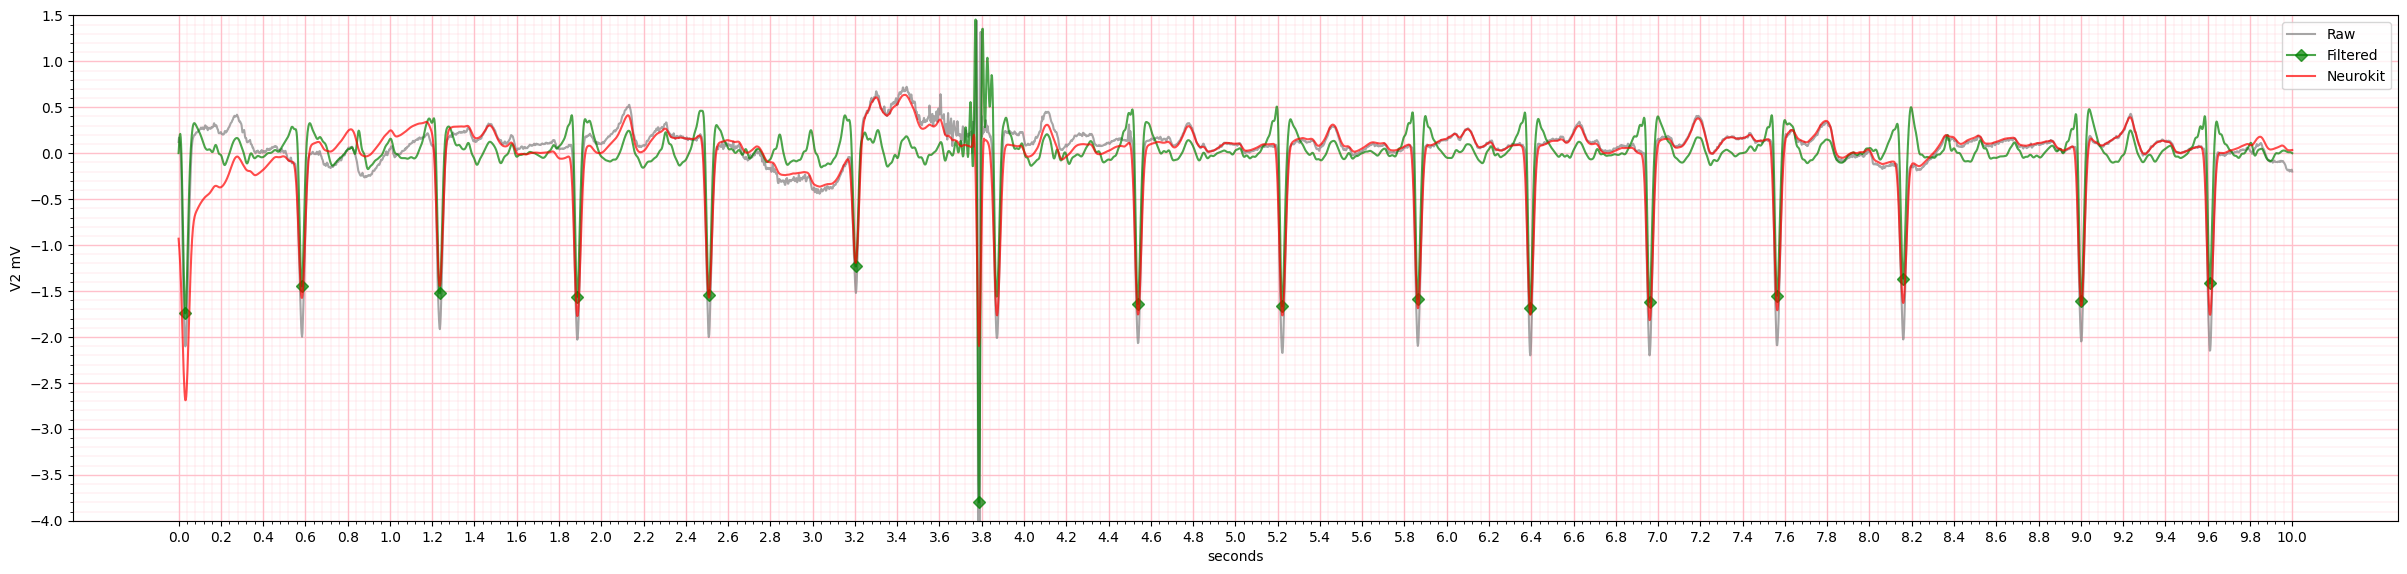

V3


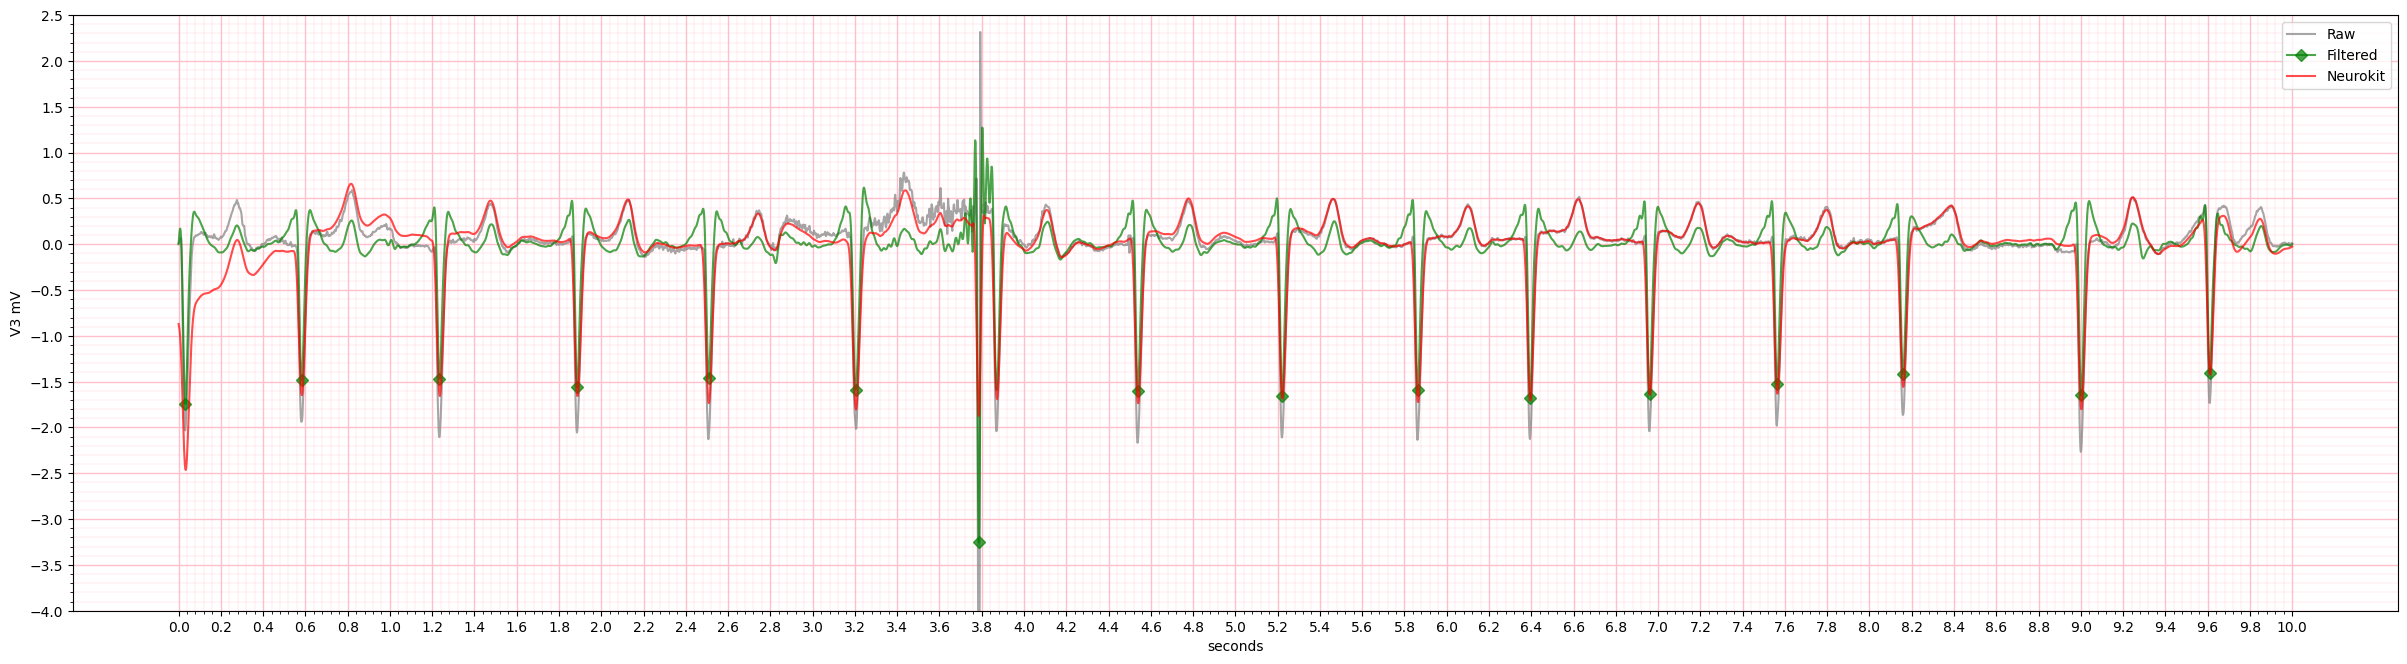

V4


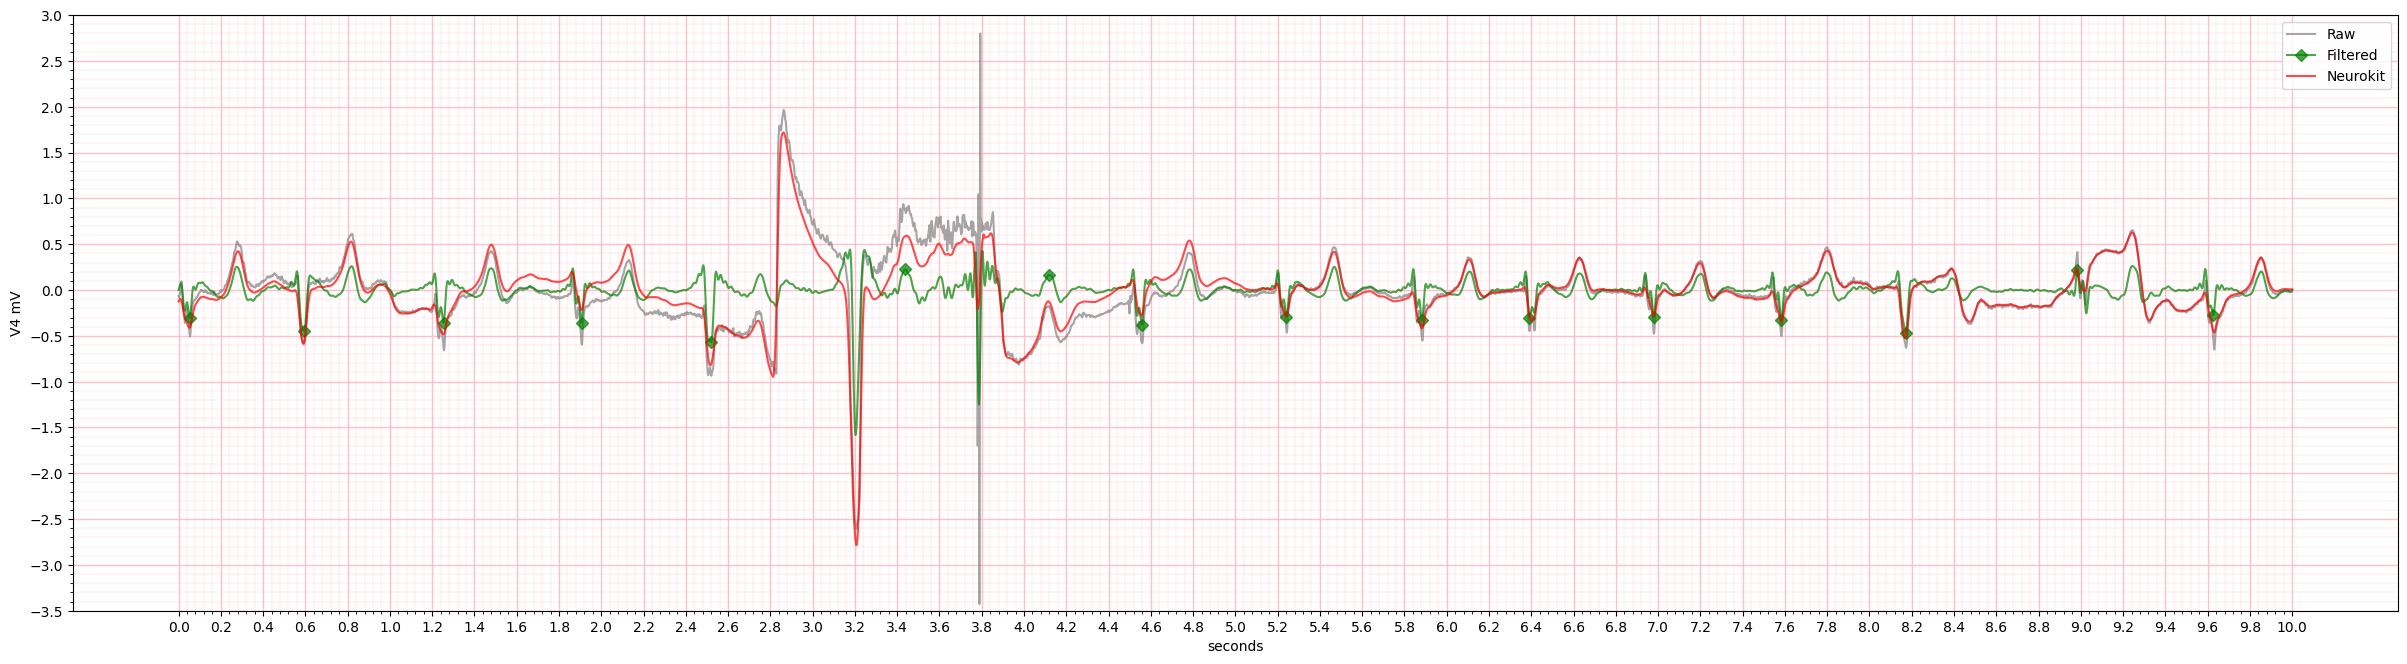

V5


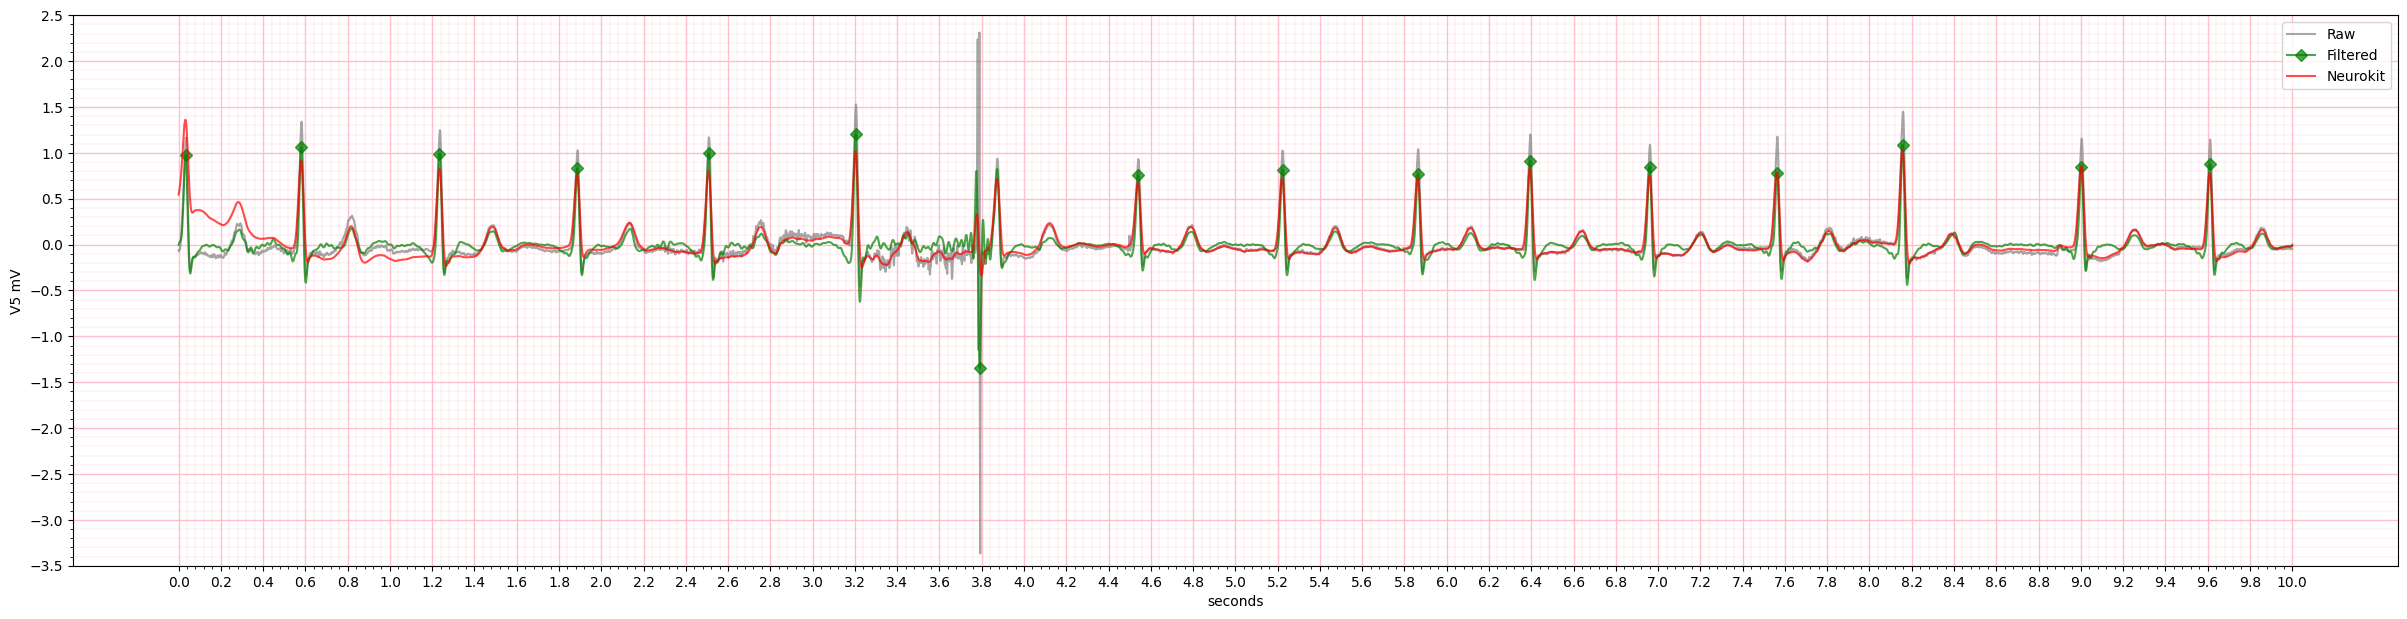

V6


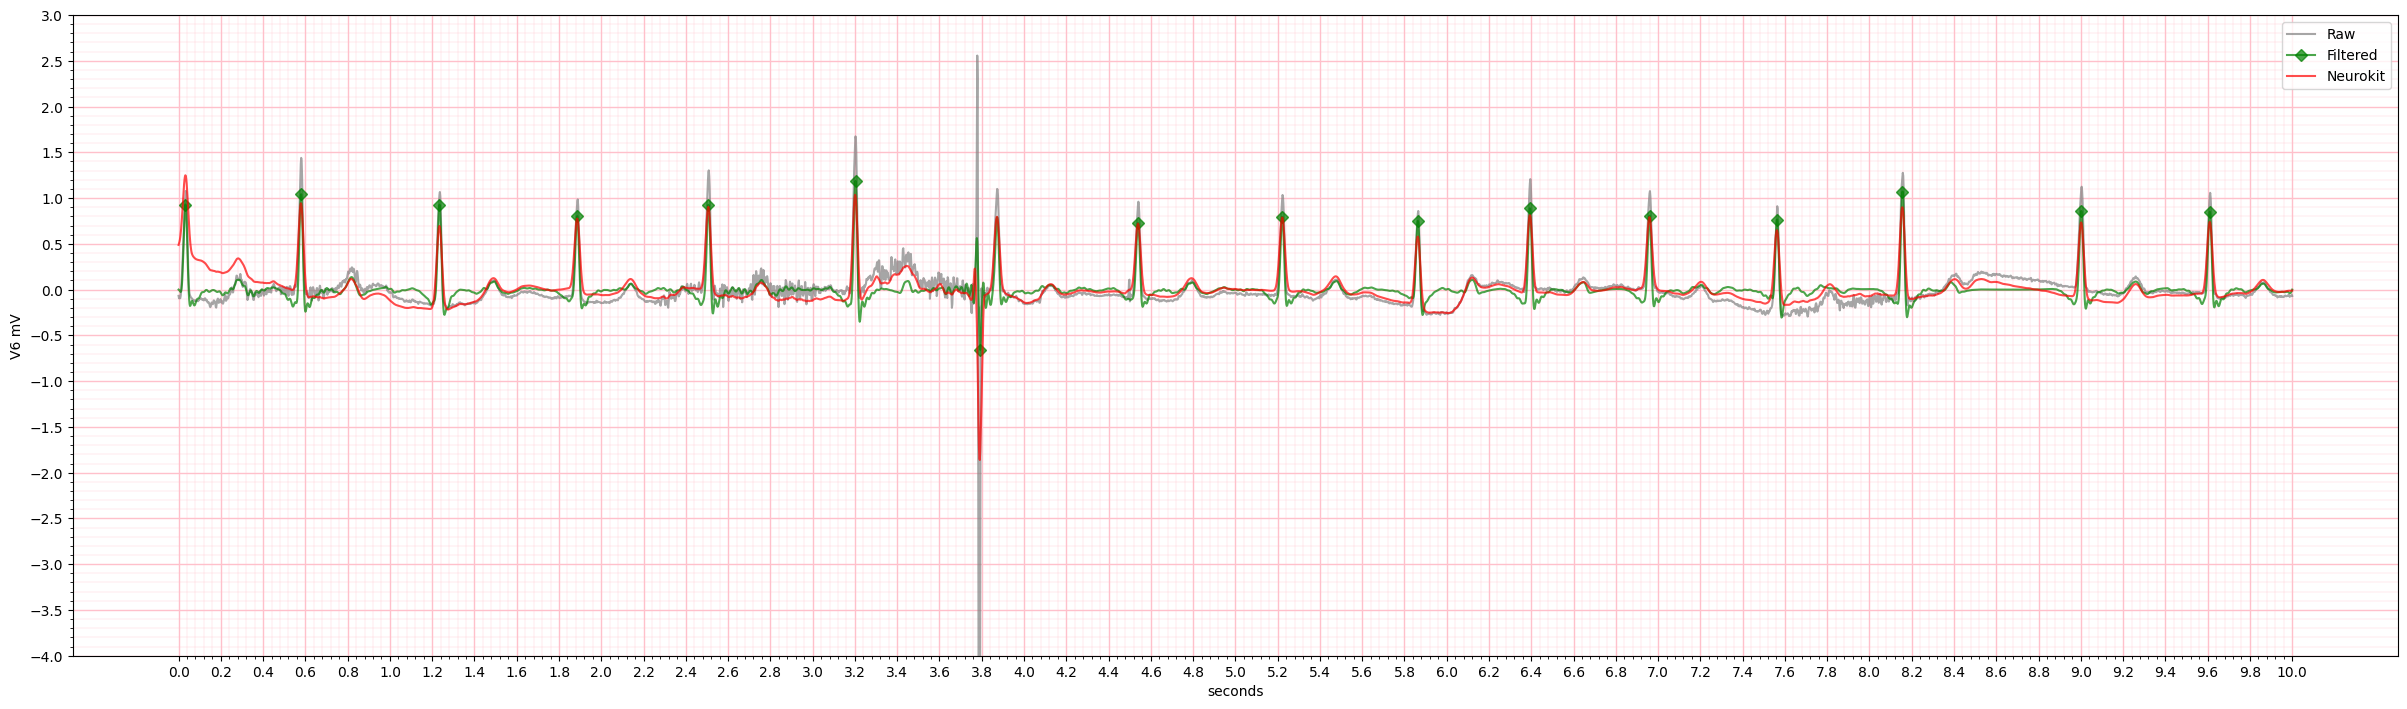

In [20]:
record_name = desc_outliers["p_signal_I_kurtosis"][1]
record = wfdb.rdrecord(record_name)
pretty_plot_record(record.p_signal, fs=record.fs, sig_names=record.sig_name)

# Further Signal Processing

How can we remove the remaining ECG artifacts and noise from the record?

In [21]:
record_name = desc_outliers["p_signal_I_kurtosis"][1]
record = wfdb.rdrecord(record_name)

# pretty_plot_record(record.p_signal, fs=record.fs, sig_names=record.sig_name)

# results = nk.bio_process(ecg=record.p_signal, sampling_rate=record.fs)


In [22]:
import os
import numpy as np
import joblib
from glob import glob

In [23]:
header_files = tuple(
    glob(os.path.join("data", "**/*.hea"), recursive=True)
)

In [24]:
d = joblib.load(".data_cache.sav")

In [25]:
for idx, row in enumerate(d[1:]):
    print(idx, row.dtype)
    break

0 [('record_name', '<U50'), ('seq_len', '<f8'), ('sampling_rate', '<f8'), ('age', '<f8'), ('sex', '<f8'), ('dx', 'O'), ('I_ECG_Rate_Mean', '<f8'), ('I_HRV_RMSSD', '<f8'), ('I_HRV_MeanNN', '<f8'), ('I_HRV_SDNN', '<f8'), ('I_HRV_SDSD', '<f8'), ('I_HRV_CVNN', '<f8'), ('I_HRV_CVSD', '<f8'), ('I_HRV_MedianNN', '<f8'), ('I_HRV_MadNN', '<f8'), ('I_HRV_MCVNN', '<f8'), ('I_HRV_pNN50', '<f8'), ('I_HRV_pNN20', '<f8'), ('I_HRV_TINN', '<f8'), ('I_HRV_HTI', '<f8'), ('I_HRV_ULF', '<f8'), ('I_HRV_VLF', '<f8'), ('I_HRV_LF', '<f8'), ('I_HRV_HF', '<f8'), ('I_HRV_VHF', '<f8'), ('I_HRV_LFHF', '<f8'), ('I_HRV_LFn', '<f8'), ('I_HRV_HFn', '<f8'), ('I_HRV_LnHF', '<f8'), ('I_HRV_SD1', '<f8'), ('I_HRV_SD2', '<f8'), ('I_HRV_SD2SD1', '<f8'), ('I_HRV_CSI', '<f8'), ('I_HRV_CVI', '<f8'), ('I_HRV_CSI_Modified', '<f8'), ('I_HRV_SampEn', '<f8'), ('I_hb_sig__abs_energy', '<f8'), ('I_hb_sig__absolute_sum_of_changes', '<f8'), ('I_hb_sig__agg_autocorrelation__f_agg_"mean"__maxlag_40', '<f8'), ('I_hb_sig__agg_autocorrelation